# Interference and Diffraction
### Mark Swartz and James Katz

## Abstract

The purpose of this experiment is to generate a computer model of the diffraction patters generated by different objects when exposed to a laser beam. The objects tested were the diffraction grating, the single slit, and the 0.8mm pinhole. The program was written to use the images taken of the experimentally generated diffraction patterns from the lab and model them as intensity arrays. 

## Introduction

Interference and diffraction are the results of interactions between multiple sources of light due to the wave-like properties of light and other forms of electro-magnetic radiation. The simplest form of this interaction is shown in the superposition principle, which states that if interfering waves are in phase, the resultant amplitude of two waves interfering is the sum of the amplitudes of the interfering waves. This is modeled by the equation

$$\vec{E_{P}} = \vec{E_{1}} + \vec{E_{2}}. $$

This effect is called constructive interference. Similarly, if two interfering waves are out of phase by $\frac{\pi}{2}$, the waves will undergo destructive interference, and the resultant amplitude will be the difference of the amplitudes of the interfering waves. 
Interference and diffraction are also affected by coherence, which is described as either spatial or temporal coherence. Spatial coherence relates to the ability of two points in space to interfere with each other, with light originating from a point source having high spatial coherence. Spatial coherence can be observed in a double slit or Young interferometer, as the interference between the point sources generated by the two slits is dependent on their spatial coordinates. Similarly, temporal coherence is dependent on the time difference of a source of light. An example of this effect is in the Michelson interferometer, where a beam splitter splits a source beam and recombines both beams with the possibility of interference. 
Because diffraction patterns are composed of multiple wave sources interacting with one another, the Fourier transform is a useful tool in modeling intensity patterns in interferograms. This equation for the complex amplitude of the transmitted light takes the form

$$\hat{t}(x) = \int{t(x)e^{-i2\pi u x}dx},$$

where $t(x)$ is an equation of the geometry of the aperture which the light is passing through, and $u = \frac{sin(\theta)}{\lambda},$ where $\theta$ is the angle of diffraction of the field after passing through the aperture. The complex amplitude can then be used in the relation $I = \hat{t}(x)\hat{t}(x)^{*}$ to find the value of the irradiance on the screen as a function of $u$. 



## Experimental Procedures

### Lab Setup

The experimental design for this lab was composed of three major parts which included the laser, the sample mount, and the diffraction screen. A pair of mirrors guided the laser beam from the source to the sample mount. The layout of this setup is shown in Figure 1. 

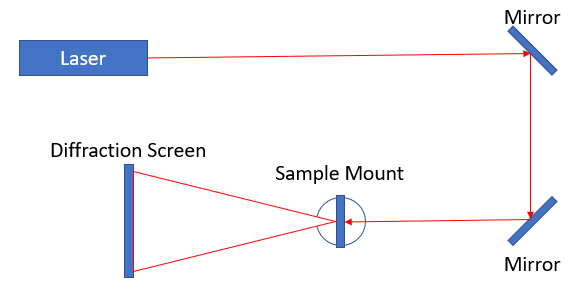

In [109]:
Image.open('labsetup.png')

**Figure 1: Schematic diagram of the overhead view of the lab setup**

In this example, the diffraction screen was a small whiteboard that provided the necessary contrast for the diffracted laser. A line of exactly 1 centimeter was drawn onto the whiteboard using a wet erase marker to provide a scale for the size of the diffraction pattern. The wet erase marker was used to avoid smudging. 
The sample mount was used to hold the objects which would cause the laser to diffract onto the screen. This mount was placed 280 mm away from the screen in the path of the laser beam. 
We made observations on each of the diffraction patterns created by each of the provided sample objects in order to get a rough idea of what effect they had on the laser beam. After making these observations, we decided to chose the single slit aperture and the 0.8mm pinhole aperture to create models of along with the diffraction grating. 
Once the samples were selected, each was placed individually on the sample mount in the path of the laser beam. With an emphasis on being steady in order to reduce motion blur, an image was then taken with a cell phone camera of the diffraction pattern generated by the sample on the screen. For these images, some ambient light needed to be added from a small flashlight in order for the scale centimeter line drawn on the diffraction screen to be visible in the image. 

## Results, analysis, and discussion

The computational part of our lab was written as a python code designed to analyze the images taken from the lab. 

In [51]:
#!pip install pint
#!pip install scikit-image
#!pip install opencv-python
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
from skimage import data
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pint
from scipy.signal import argrelextrema

control = Image.open('control.png')
singleslit = Image.open('singleslit.png')
diffraction_grating = Image.open('diffraction_grating.png')
pinhole = Image.open('pinhole.png')
crop_grating = Image.open('crop_grating.png')

u = pint.UnitRegistry()
%matplotlib inline

After importing the collected images and setting the size of the plot of the light intensity of the images, the first plot made was that of the control laser. Without any source of diffraction, this shows a single point of high intensity spot of light that quickly tappers off to the ambient intensity on the screen. 

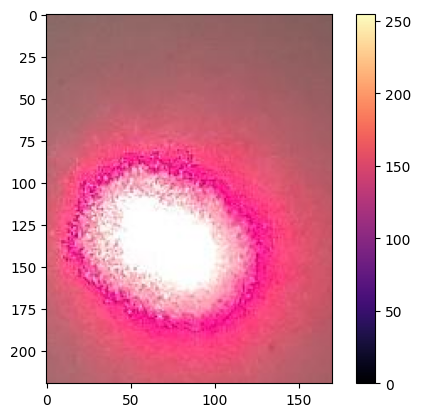

In [52]:
top = 650
bottom = 870
left = 850
right = 1020

crop_control = control.crop((left,top,right,bottom))
cmap = plt.cm.magma
plt.imshow(crop_control, cmap=cmap)
plt.colorbar()

In the code, we make use of objects to classify the parameters and types of the apertures.  We can then call those objects when analysing our results.

In [141]:
class calculate_diffraction:
    '''
    Calculates diffraction using FFT and IFFT in two dimensions.
    '''
    def __init__(self,diffraction,variety,image,top,bottom,left,right):
        '''
        Initial variables to create the object
        '''
        self.diffraction = diffraction # Specifies type geometry of diffraction
        self.image = image # Pulls the experimental image
        self.top = top # Top, Bottom, Left and Right are the crop dimensions
        self.bottom = bottom
        self.left = left
        self.right = right
        self.variety = variety # 
        
    def image_processing(self):
        '''
        Takes the cropped image and scales it to a 1 cm line included in each image.
        Then uses that scale to create x-ticks for our simulated graphs later.
        Function must be called whenever you want to compare a simulation to experimental image.
        '''
        string1 = 'crop_'
        string2 = '.png'
        path = string1 + self.diffraction + string2
        self.path = path
        crop = plt.imread(self.path)
        self.crop = crop
        height, w, _ = crop.shape
        self.height = height
        self.w = w
        width = right_scale-left_scale
        self.width = width
        scale_length = self.width
        self.scale_length = scale_length
        pixels_per_cm = self.scale_length
        self.pixels_per_cm = pixels_per_cm
        x_ticks = np.arange(0, self.w, self.pixels_per_cm)
        self.x_ticks = x_ticks
        
    def set_scale(self,top_scale,bottom_scale,left_scale,right_scale):
        '''
        Instantiates the scale factor from the experimental image.
        '''
        self.top_scale = top_scale
        self.bottom_scale = bottom_scale
        self.left_scale = left_scale
        self.right_scale = right_scale
        
    def set_R(self,R):
        '''
        If a pinhole aperture is being used, it is necessary to set_R for the radius of the pinhole.
        '''
        self.R = R
        
    def get_R(self):
        '''
        This function will pull the instantiated radius of a pinhole.
        '''
        return self.R
    
    def set_D(self,D):
        '''
        This function sets the width of the slit(s).
        '''
        self.D = D
        
    def get_D(self):
        '''
        This function retrieves the instantiated width of the slit(s).
        '''
        return self.D
    
    def set_lam(self,lam):
        '''
        This function sets the value for lambda, the wavelength of light.
        '''
        self.lam = lam
        k = 2*np.pi / (self.lam)
        self.k = k
        
    def get_lam(self):
        '''
        This function retrieves the instantiated value for lambda, the wavelength of light.
        '''
        return self.lam
    
    def get_k(self):
        '''
        This function retrieves the instantiated momentum magnitude of the light.
        '''
        self.k = k
        
    def set_z(self,z):
        '''
        This function sets the distance between the apeture and the screen.
        '''
        self.z = z
        
    def get_z(self):
        '''
        This function retrieves the instantiated distance between the aperture and the screen.
        '''
        return self.z
    
    def set_h(self,h):
        '''
        This function sets the height of the slit(s).
        '''
        self.h = h
        
    def get_h(self):
        '''
        This function retrieves the instantiated value of the height of the slit(s).
        '''
        return self.h
    
    def set_slits(self,horizontal,vertical):
        '''
        This function allows the user to specify how many slits to place in a grid - horizontal by vertical
        '''
        self.horizontal = horizontal
        self.vertical = vertical
    
    def set_S(self,S):
        '''
        This function sets the spacing between the slits.
        '''
        self.S = S
        
    '''
    If one or more slits are being simulated, the geometry (U0), will be calculated differently
    depending on whether horizontal or vertical is even or odd and vice-versa.
    '''
        
    def even_even(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(1,num_horiz,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(1,num_vert,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(1,num_horiz,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(1,num_vert,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
        
    def odd_odd(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(0,num_horiz+1,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(0,num_vert+1,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(0,num_horiz+1,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(0,num_vert+1,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
    
    def even_odd(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(1,num_horiz,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(0,num_vert+1,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(1,num_horiz,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(0,num_vert+1,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
        
    def odd_even(self,num_horiz,num_vert):
        
        U0 = False
        for i in range(0,num_horiz+1,2):
            term1 = (np.abs(self.xv-i*self.S/2)< self.D/2)
            for j in range(1,num_vert,2):
                term2 = (np.abs(self.yv-j*self.S/2)<self.h/2) + (np.abs(self.yv+j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2

        for i in reversed(range(0,num_horiz+1,2)):
            term1 = (np.abs(self.xv+i*self.S/2)< self.D/2)
            for j in reversed(range(1,num_vert,2)):
                term2 = (np.abs(self.yv+j*self.S/2)<self.h/2) + (np.abs(self.yv-j*self.S/2)<self.h/2)
                U0 = U0 + term1*term2
        U0 = U0.astype(float)
        return U0
    
    def set_x(self,x):
        '''
        This function sets the size of the mesh grid used to simulate the apertures.
        As it currently stands, the combined size and spacings of the slits can not be
        greater than the length chosen for x.
        
        The function then checks parity of the number of horizontal vs vertical slits
        and calls the appropriate function to calculate the geometry.
        '''
        self.x = x
        xv,yv = np.meshgrid(self.x,self.x)
        self.xv = xv
        self.yv = yv
        if self.variety == 'pinhole':
            U0 = xv**2 + yv**2 < self.R**2
            U0 = U0.astype(float)
            self.U0 = U0
        elif self.variety == 'slits':
            
            if self.horizontal % 2 == 0 and self.vertical %2 == 0:
                U0 = self.even_even(self.horizontal,self.vertical)
                self.U0 = U0
                
            if self.horizontal % 2 != 0 and self.vertical %2 != 0:
                U0 = self.odd_odd(self.horizontal,self.vertical)
                self.U0 = U0
                
            if self.horizontal % 2 == 0 and self.vertical %2 != 0:
                U0 = self.even_odd(self.horizontal,self.vertical)
                self.U0 = U0
                
            if self.horizontal % 2 != 0 and self.vertical %2 == 0:
                U0 = self.odd_even(self.horizontal,self.vertical)
                self.U0 = U0

    def get_U0(self):
        '''
        This function retrieves the instantiated aperture geometry.  This will return a matrix.
        '''
        return self.U0
    
    def get_mesh(self):
        '''
        This function retrieves the instantiated dimensions of the simulation mesh, on which
        the aperature(s) are placed.
        '''
        return self.xv,self.yv
    
    def get_x(self):
        '''
        This function retrieves the instantiated length of the simulation mesh.
        '''
        return self.x
    
    def compute_U(self):
        '''
        Regardless of geometry chosen, this function takes the inverse 2-dimensional
        Fast Fourier Transform (FFT) of the geometry to calculate the diffraction pattern.
        '''
        A = fft2(self.U0)
        self.A = A
        self.kx = 2*np.pi * fftfreq(len(self.x), np.diff(self.x)[0])
        self.kxv, self.kyv = np.meshgrid(self.kx,self.kx)
        self.k = 2*np.pi/self.lam
        U = ifft2(self.A*np.exp(1j*self.z*np.sqrt(self.k**2-self.kxv**2-self.kyv**2)))
        self.U = U
        
    def sim_aperture(self):
        '''
        This function returns a plot of the mesh and apperatures placed thereon.
        '''
        string = str(self.diffraction) + ' aperture'
        plt.figure(figsize=(5,5))
        plt.pcolormesh(self.xv,self.yv,self.U0)
        plt.title(string)
        plt.xlabel('X-Position [mm]')
        plt.ylabel('Y-Position [mm]')
        return plt.show()

    def plot(self):
        '''
        This function returns the plot of the diffraction pattern on the left
        and the plot of the scaled diffraction pattern of the experimental image on the right.
        '''
        rows = 1
        columns = 2
        fig, (ax1, ax2) = plt.subplots(rows,columns,figsize = (10,5))
        ax1.pcolormesh(self.xv,self.yv,np.abs(self.U), cmap='inferno')
        ax1.set(title='Simulated Diffraction Pattern', ylabel='$y$ [cm]', xlabel='$x [cm]$')
        ax2.imshow(self.image)
        ax2.set(title='Experimental Diffraction Pattern', ylabel='$y$ [cm]', xlabel='$x [cm]$')
        ax2.set_xticks(self.x_ticks)
        ax2.set_xticklabels([f"{i // self.pixels_per_cm} cm" for i in self.x_ticks], rotation=45)
        return plt.show()
        
    def plot_exp_image(self):
        '''
        This function plots the experimental image.
        '''
        
        fig, ax = plt.subplots()
        ax.imshow(self.crop)
        ax.set_xticks(self.x_ticks)
        ax.set_xticklabels([f"{i // self.pixels_per_cm} cm" for i in self.x_ticks], rotation=45)
        plt.show()
        
        return plt.show()
    
    def get_extrema_sim(self):
        '''
        This function returns a plot of a 'slice' of the simulated diffraction pattern.  (Intensity vs. Position)
        '''

        y = np.abs(self.U)[250]
        maxima_idx = argrelextrema(y, np.greater)[0]
        minima_idx = argrelextrema(y, np.less)[0]
        fig, ax = plt.subplots()
        plt.plot(self.x, y)
        plt.plot(self.x[maxima_idx], y[maxima_idx], 'ro')
        plt.plot(self.x[minima_idx], y[minima_idx], 'bo')
        plt.xlabel('Distance [cm]')
        plt.ylabel('Relative Intensity')
        plt.title('Simulation slice and extrema')
        return plt.show()
    
    def get_extrema_exp(self):
        '''
        This function calculates the extrema of the experimental image.
        '''

        img = Image.open(self.path).convert('L')
        img_arr = np.asarray(img)
        max_col = np.argmax(np.sum(img_arr, axis=0))
        intensity_values = img_arr[:, max_col]
        maxima_idx = argrelextrema(intensity_values, np.greater)[0]
        minima_idx = argrelextrema(intensity_values, np.less)[0]
        fig, ax = plt.subplots()
        ax.plot(intensity_values)
        ax.plot(maxima_idx, intensity_values[maxima_idx], 'ro')
        ax.plot(minima_idx, intensity_values[minima_idx], 'bo')
        ax.set(title='Experimental slice and extrema', ylabel='Relative Intensity', xlabel='Position [cm]')
        x_ticks = np.arange(0, img_arr.shape[0], self.pixels_per_cm)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f"{i // (self.pixels_per_cm/10)} mm" for i in x_ticks], rotation=45)
        plt.show()

The second plot was made from the image of the diffraction pattern for the single slit aperture. This image isolated the diffraction pattern by sizing the image to be wider on the x axis than the y axis. The image showed a diffraction pattern of high intensity at the point where the single slit was centered, and diffracts horizontally with lower intensities to the left and right of center. Peaks and troughs of intensity can also be observed based on the horizontal position of the incident light on the screen. 

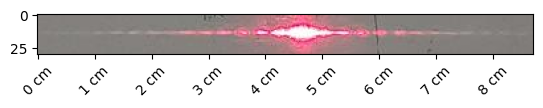

In [142]:
top = 840
bottom = 870
left = 800
right = 1175

top_scale = 400
bottom_scale = 600
left_scale = 747
right_scale = 790

crop_single = singleslit.crop((left,top,right,bottom))

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_single.png'
#crop_single.save(path)

single_slit = calculate_diffraction('single','slits',crop_single,top,bottom,left,right)
single_slit.set_scale(top_scale,bottom_scale,left_scale,right_scale)
single_slit.set_slits(1,1)
single_slit.set_S(3*u.mm)
single_slit.image_processing()
single_slit.set_h(5*u.mm)
single_slit.set_R('None')
single_slit.set_lam(660 * u.nm)
single_slit.set_D(1 * u.mm)
single_slit.set_x(np.linspace(-5,5,1600) * u.cm)
single_slit.set_z(700*u.cm)
single_slit.compute_U()
single_slit.plot_exp_image()

We then create the simulation aperature for a single slit.

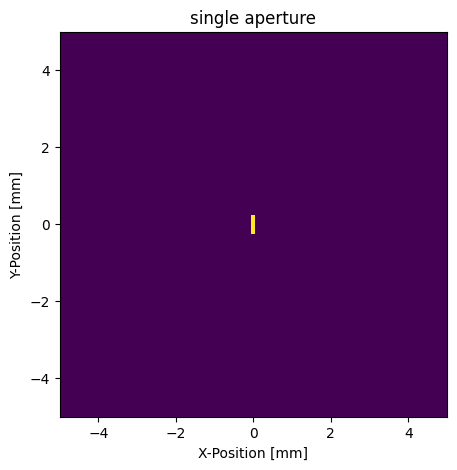

In [143]:
single_slit.sim_aperture()

We plot the simulated diffraction pattern next to the experimental one.  The scales are in cm and the images match up.  The extrema of the simulation are hard to see, but it apears the most intense region is around 1 cm wide.

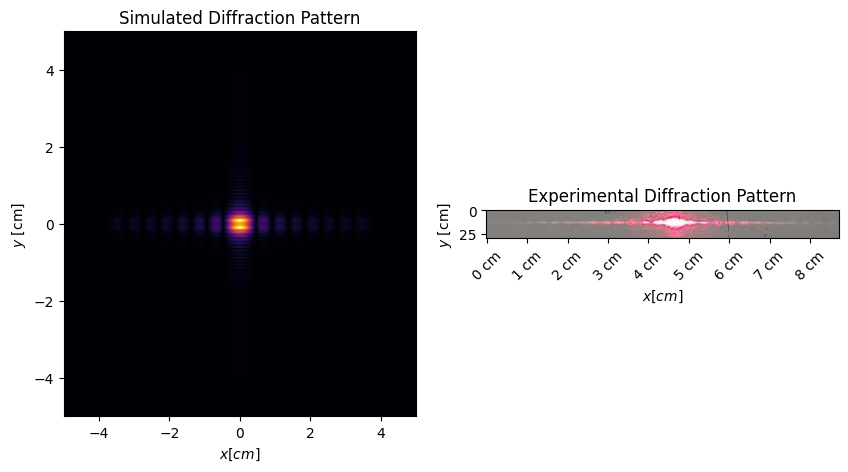

In [144]:
single_slit.plot()

We then make a slice through the most intense horizontal regions of both the simulated and experimental diffraction pattern.  We label the maxima in red and minima in blue.  The experimental intensity pattern's scale is a bit off because our resolution is in cm.  It can be seen that the intensity length is over about 1 cm.  Otherwise, the two are in good agreement.

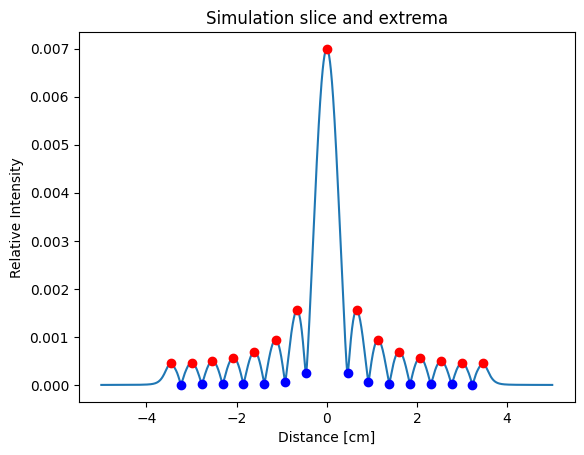

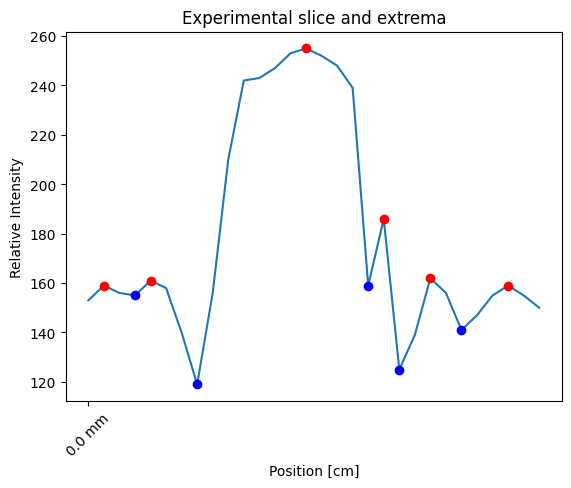

In [145]:
single_slit.get_extrema_sim()
single_slit.get_extrema_exp()

Like the single slit diffraction pattern, the image of the diffraction pattern of the pinhole aperture was also resized in order to fit the pattern in the image. The pattern created by the pinhole is observed to look initially similar to the control image, with the exception that the light is diffracting at greater angles. This results in a pattern of high intensity at the center of the pinhole which decreases in intensity proportionally to the distance from this center point at a slower rate than the drop of intensity of the control pattern. 

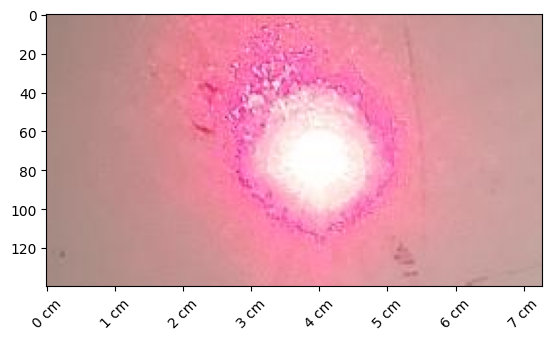

In [146]:
top = 710
bottom = 850
left = 845
right = 1100

top_scale = 400
bottom_scale = 500
left_scale = 772
right_scale = 807

crop_pinhole = pinhole.crop((left,top,right,bottom))

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_pinhole.png'
#crop_pinhole.save(path)

pinhole_diffraction = calculate_diffraction('pinhole','pinhole',crop_pinhole,top,bottom,left,right)
pinhole_diffraction.set_scale(top_scale,bottom_scale,left_scale,right_scale)
pinhole_diffraction.image_processing()
pinhole_diffraction.set_R(0.8*u.mm)
pinhole_diffraction.set_h('None')
pinhole_diffraction.set_lam(670 * u.nm)
pinhole_diffraction.set_D(0.8 * u.mm)
pinhole_diffraction.get_R()
pinhole_diffraction.set_x(np.linspace(-3,3,1600) * u.cm)
pinhole_diffraction.set_z(1000*u.cm)
pinhole_diffraction.compute_U()
pinhole_diffraction.plot_exp_image()

We modelled the simulation aperture for a pinhole below.

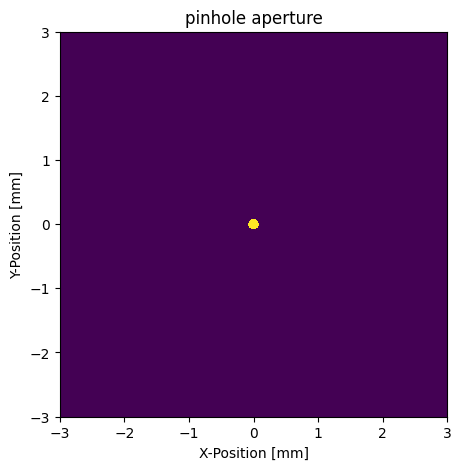

In [147]:
pinhole_diffraction.sim_aperture()

The scales for the pinhole match up, but the pattern is a bit off.  Theoretically, the diffraction pattern should be the one in the simulation.  However, due to the whiteboard we were reflection off of and cell phone camera we used, we lost quite a bit of resolution.

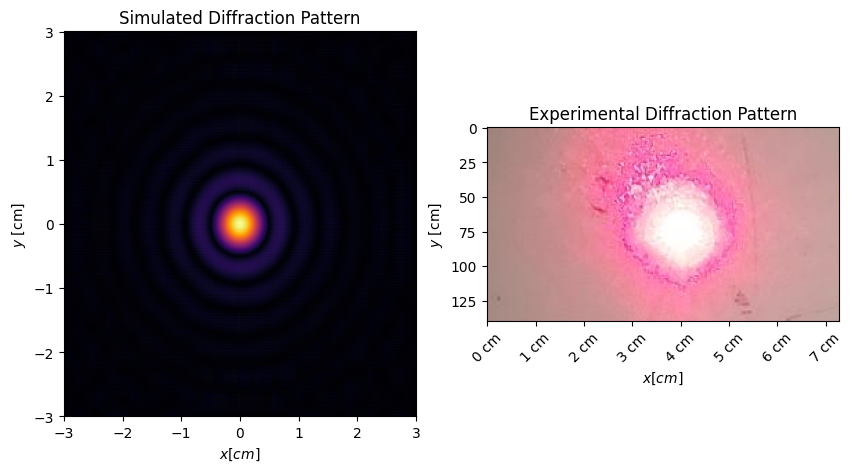

In [148]:
pinhole_diffraction.plot()

We analysed the 'slice' of the maximum intensity through both our simulation and experimental diffraction pattern.  Just like in the 2-d diffraction pattern, the 1-d pattern goes from maximum to minimum at every interference point.  Our experimental 1-d diffraction pattern matches up to the bad resoluion discussed earlier.  Again, the white board and the camera caused a lot of error.

The maxima are in red and the minima are in blue.

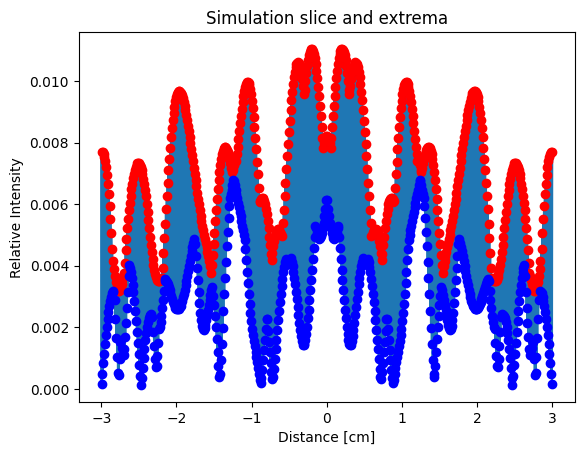

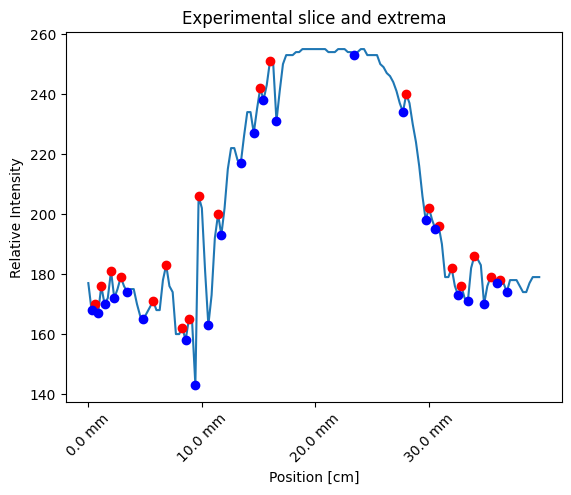

In [149]:
pinhole_diffraction.get_extrema_sim()
pinhole_diffraction.get_extrema_exp()

Lastly, we created an object to handle the diffraction grating.  While interesting, this one gave us the most error.  We weren't sure how many grids there were per milimeter and tried to match our simulation to the experimental diffraction pattern.  Since the light incident on the grating had a diameter, the pattern should be circular.  However, our code didn't account for the diameter of light, which was likely the cause in the difference.

Also, the actual grating likely contained hundreds if not thousands of apertures.  Our code isn't able to handle arrays of that magnitude.  We ended up creating an aperture grid of 10x10.

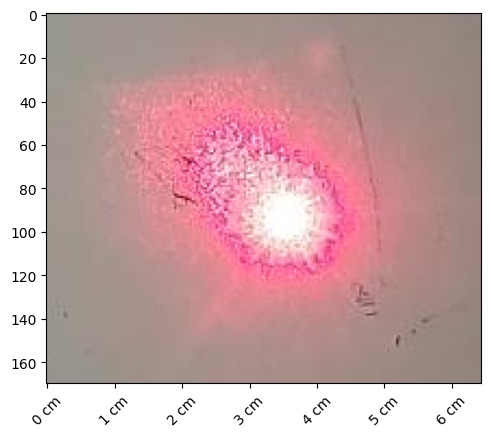

In [150]:
top = 700
bottom = 870
left = 950
right = 1150

top_scale = 550
bottom_scale = 640
left_scale = 767
right_scale = 798

grating = diffraction_grating.crop((left,top,right,bottom))

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_grating.png'
#grating.save(path)

grating = calculate_diffraction('grating','slits',crop_grating,top,bottom,left,right)
grating.set_slits(10,10)
grating.set_S(3*u.mm)
grating.set_scale(top_scale,bottom_scale,left_scale,right_scale)
grating.image_processing()
grating.set_R('None')
grating.set_h(1*u.mm)
grating.set_lam(670 * u.nm)
grating.set_D(1 * u.mm)
grating.get_R()
grating.set_x(np.linspace(-3,3,1600) * u.cm)
grating.set_z(1000*u.cm)
grating.compute_U()
grating.plot_exp_image()

The aperture geometry is what we expected.  The actual grating used in the experiment likely contained magnitude more apertures.

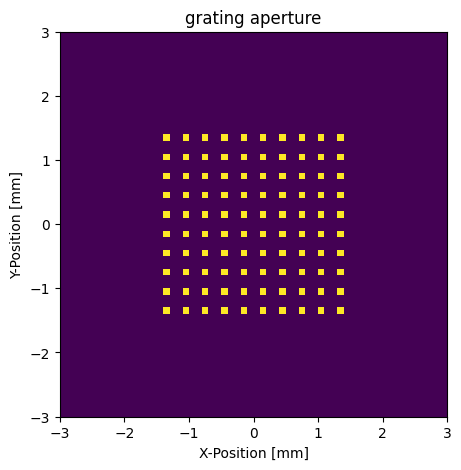

In [151]:
grating.sim_aperture()

The diffraction grating definately gave us the most error.  As can be seen with the simulated and experimental diffraction patterns below, the geometric difference is likely caused by our lack of using a diameter for the laser beam.  However, the tapering off of the intensity is a good sign.

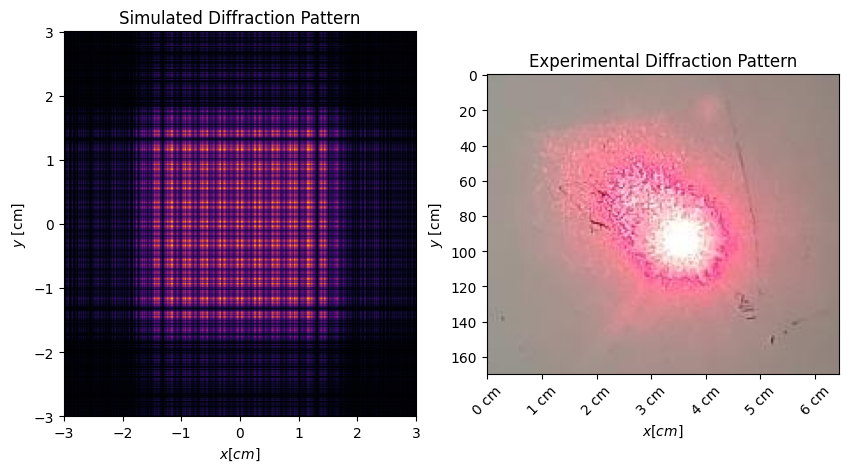

In [152]:
grating.plot()

When taking a 'slice' of both the simulated and experimental diffraction pattern, it seems like our data matches up well with respect to intensity differences.

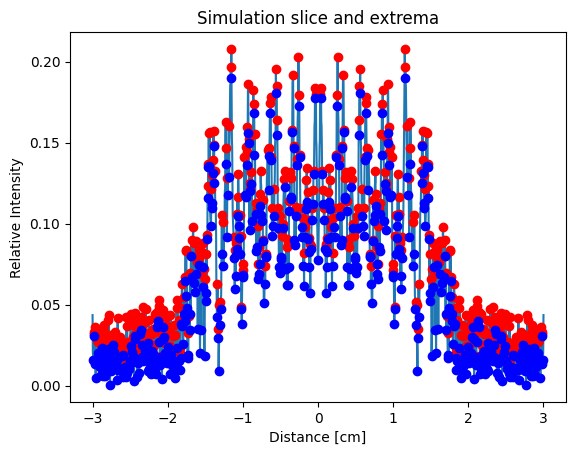

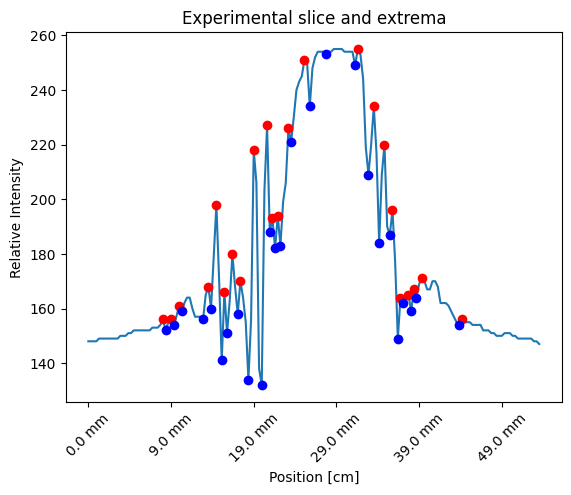

In [153]:
grating.get_extrema_sim()
grating.get_extrema_exp()

## Conclusions

For the most part, our simulations matched up well with our experimental diffraction patterns.  There was a bit of error likely caused by the white board used as a screen and the cell phone camera used to capture the data.  We took the pictures in the dark in order to avoid error, but we would likely need higher quality equiptment to minimize error further.  The pattern which gave us the most error was the diffraction grating.  We weren't sure how many apertures there were, but there were likely thousands.  We modelled our simulated grating with 100 apertures.  Since our laser has a circlar cross-section, the simulation doesn't quite match up very well.  If we were to model the simulation with a circular laser, we would likely get more agreement.

We set scales for our images by writing a centimeter mark on the board.  To put the cropped images to scale, we measured the pixel to cm scale of each image.  We were then able to match up the scales of our simulations by chaning parameters.